This notebook conducts and analyzes linear regression for the training set HSE06 bandgaps. It does cross-validation for the three basic types of linear regression (ordinary least squares, ridge regression, and lasso) and completes hyper-parameter tuning for ridge regression and lasso. Each regression type is carried out for five features set: 
- principal components from stoich45 ('Stoich45 PCs')
- features from stoich 45 mutually selected by various methods ('Stoich45 intersection')
- principal components from the 'smoothed' eigenspectra of the sine Coulomb matrices ('SCM PCs')
- 'Stoich45 PCs' and 'SCM PCs' together
- 'Stoich45 intersection' and 'SCM PCs' together

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

##### import feature sets:

In [363]:
feature_sets = []
feature_set_labels = []

# import three base feature sets
feature_sets.append(pd.read_csv('../data/datasets_main/Stoich45_PCA_dataset.csv', sep=','))
feature_set_labels.append('Stoich45 PCs')
# ... rename principal component columns to be more descriptive
feature_sets[0] = feature_sets[0].rename(columns = dict([[str(i), 'stoich45 PC '+str(i+1)] for i in range(8)]))

feature_sets.append(pd.read_csv('../data/datasets_main/Stoich45_FeatureSelected_dataset.csv', sep=','))
feature_set_labels.append('Stoich45 intersection')

feature_sets.append(pd.read_csv('../data/datasets_main/SCM_PCA_trainingStoich45_dataset.csv', sep=','))
feature_set_labels.append('SCM PCs')

# merge to form last two
feature_sets.append(feature_sets[0].merge(feature_sets[2]))
feature_set_labels.append('Stoich45 PCs + SCM PCs')

feature_sets.append(feature_sets[1].merge(feature_sets[2]))
feature_set_labels.append('Stoich45 intersection + SCM PCs')

# drop MOF column and rename target in all feature sets
feature_sets = [fs.drop(columns = ['MOF']).rename(columns = {'outputs.hse06.bandgap': 'HSE06 Bandgap'}) for fs in feature_sets]

##### make defintions for cross validation:

In [364]:
target = 'HSE06 Bandgap'
kfold = KFold(n_splits = 4, shuffle = True, random_state = 1234)

def get_mean_cv_mse(model, df_feature_set):
     return -cross_val_score(
         model,
         X = df_feature_set.drop(columns = [target]), y = df_feature_set[target],
         cv = kfold, scoring = 'neg_mean_squared_error',
         n_jobs = 4
     ).mean()

## Ordinary Least Squares Linear Regression

#### cross-validation:

In [365]:
ols_cv_mse = np.zeros((len(feature_sets),))
print(f"{'Feature Set':<35}{'Cross-Validation MSE'}")

for (i, fs) in enumerate(feature_sets):
    ols_cv_mse[i] = get_mean_cv_mse(LinearRegression(),fs)
    print(f"{feature_set_labels[i]:<35}{round(ols_cv_mse[i],6)}")

Feature Set                        Cross-Validation MSE
Stoich45 PCs                       0.803314
Stoich45 intersection              0.685575
SCM PCs                            0.862338
Stoich45 PCs + SCM PCs             0.752578
Stoich45 intersection + SCM PCs    0.670345


#### TODO - analysis:
Is there any structure in the residuals?

## Ridge Regression
... with prescaling

#### hyper-parameter tuning via cross-validation:
Tune the hyper-parameter alpha 'manually' by repeating the regression for a range of alpha values so that a minimum in cross-validation MSE is 'smoothly resolved' graphically. Then pick the alpha from that range that minimizes the MSE.

Feature Set                         Cross-Validation MSE      alpha
Stoich45 PCs                        0.80331                   23.0
Stoich45 intersection               0.685502                  0.61
SCM PCs                             0.862325                  42.0
Stoich45 PCs + SCM PCs              0.752497                  90.0
Stoich45 intersection + SCM PCs     0.670129                  1.32


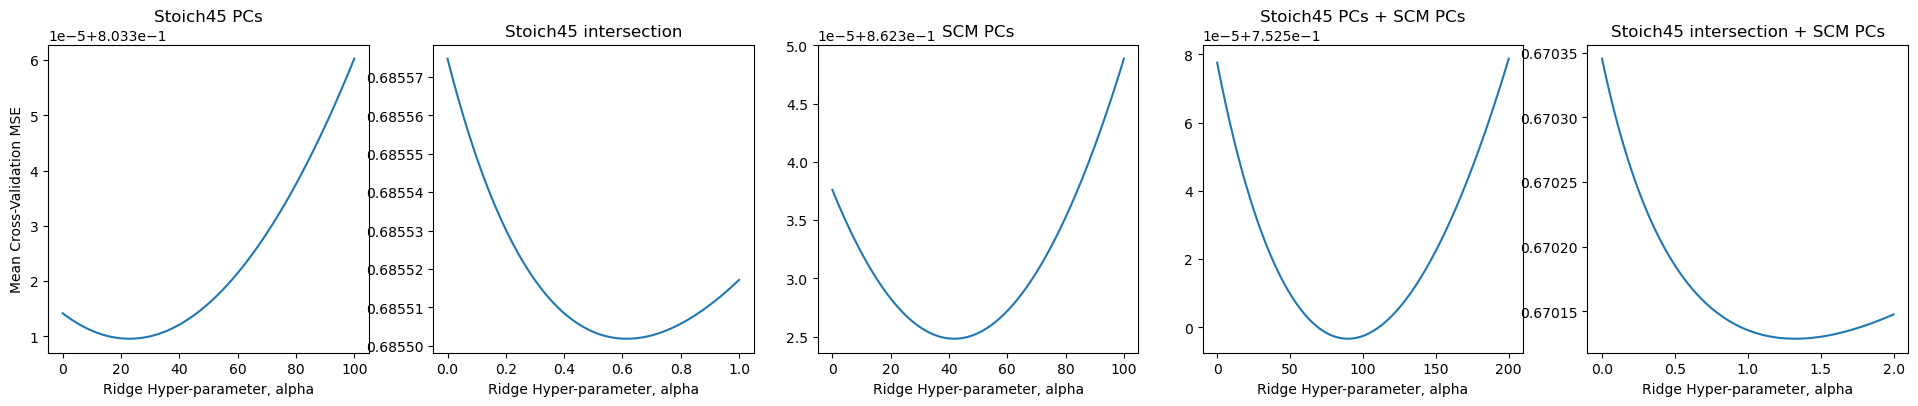

In [369]:
base_alpha_list = np.arange(0.0,1.01,0.01)
ridge_alpha_scale_list = [100.0, 1.0, 100.0, 200.0, 2.0] #set manually to resolve minima

ridge_cv_mse = np.zeros((len(feature_sets), len(base_alpha_list)))
ridge_optimal_alpha = np.zeros((len(feature_sets),))

print(f"{'Feature Set':<35} {'Cross-Validation MSE':<25} {'alpha'}")
fig, axs = plt.subplots(1, 5, figsize=(24, 4))

for (i, fs) in enumerate(feature_sets):
    alpha_list = ridge_alpha_scale_list[i] * base_alpha_list
    for (j, alpha) in enumerate(alpha_list):
        model = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=alpha))])
        ridge_cv_mse[i,j] = get_mean_cv_mse(model, fs)
    
    j_min = np.argmin(ridge_cv_mse[i])
    ridge_optimal_alpha[i] = alpha_list[j_min]
    
    print(f"{feature_set_labels[i]:<35} {round(ridge_cv_mse[i,j_min], 6):<25} {round(ridge_optimal_alpha[i],6)}")
    
    axs[i].plot(alpha_list,ridge_cv_mse[i,:])
    axs[i].set_title(feature_set_labels[i])
    axs[i].set_xlabel('Ridge Hyper-parameter, alpha')
    if i == 0:
        axs[i].set_ylabel('Mean Cross-Validation MSE')

#### analysis:
The cross-validation MSEs are not significantly improved relative to OLS. Regularization does not seem to be doing much. Does this imply that these were good choices for features?

In [370]:
print(f"{'Feature Set':<35} {'Improvement in CV MSE over OLS'}")
for (i, fs) in enumerate(feature_sets):
    print(f"{feature_set_labels[i]:<35} {ols_cv_mse[i] - min(ridge_cv_mse[i]):.10f}")

Feature Set                         Improvement in CV MSE over OLS
Stoich45 PCs                        0.0000046053
Stoich45 intersection               0.0000728604
SCM PCs                             0.0000127820
Stoich45 PCs + SCM PCs              0.0000808548
Stoich45 intersection + SCM PCs     0.0002164544


## Lasso
... with pre-scaling.

#### hyper-parameter tuning via cross-validation:
as done for ridge regression above

Feature Set                         Cross-Validation MSE      alpha
Stoich45 PCs                        0.803313                  0.00029
Stoich45 intersection               0.685542                  2.6e-05
SCM PCs                             0.862216                  0.0033
Stoich45 PCs + SCM PCs              0.752563                  0.00047
Stoich45 intersection + SCM PCs     0.670329                  4.4e-05


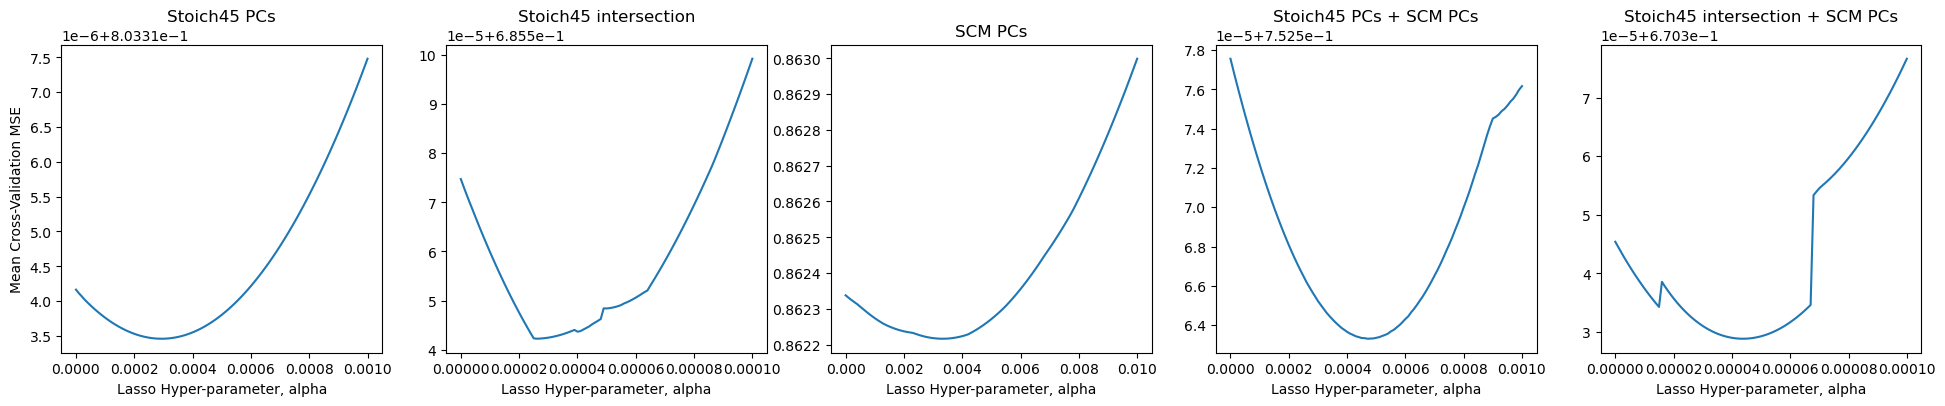

In [371]:
base_alpha_list = np.arange(0.0,1.01,0.01)
lasso_alpha_scale_list = [0.001, 0.0001, 0.01, 0.001, 0.0001] #set manually to resolve minima

lasso_cv_mse = np.zeros((5, len(base_alpha_list)))
lasso_optimal_alpha = np.zeros((len(feature_sets),))

print(f"{'Feature Set':<35} {'Cross-Validation MSE':<25} {'alpha'}")
fig, axs = plt.subplots(1, 5, figsize=(24, 4))

for (i, fs) in enumerate(feature_sets):
    alpha_list = lasso_alpha_scale_list[i] * base_alpha_list
    for (j, alpha) in enumerate(alpha_list):
        if alpha == 0.0:
            model = LinearRegression()
        else:
            model = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=alpha, max_iter=100000))])
        lasso_cv_mse[i,j] = get_mean_cv_mse(model, fs)
    
    j_min = np.argmin(lasso_cv_mse[i])
    lasso_optimal_alpha[i] = alpha_list[j_min]
    
    print(f"{feature_set_labels[i]:<35} {round(lasso_cv_mse[i,j_min], 6):<25} {round(lasso_optimal_alpha[i],6)}")
    
    axs[i].plot(alpha_list,lasso_cv_mse[i,:])
    axs[i].set_title(feature_set_labels[i])
    axs[i].set_xlabel('Lasso Hyper-parameter, alpha')
    if i == 0:
        axs[i].set_ylabel('Mean Cross-Validation MSE')

#### analysis:
Across all feature sets, alpha had to be very small to resolve any minimum. But then the above curves in some cases are somewhat jagged. Is there a way to improve this? Does it matter? As with ridge regression, cross-validation MSE are not significantly improved relative to OLS.

In [372]:
print(f"{'Feature Set':<35} {'Improvement in CV MSE over OLS'}")
for (i, fs) in enumerate(feature_sets):
    print(f"{feature_set_labels[i]:<35} {ols_cv_mse[i] - min(lasso_cv_mse[i]):.10f}")

Feature Set                         Improvement in CV MSE over OLS
Stoich45 PCs                        0.0000007047
Stoich45 intersection               0.0000324843
SCM PCs                             0.0001212806
Stoich45 PCs + SCM PCs              0.0000142458
Stoich45 intersection + SCM PCs     0.0000165483


Were any features 'zeroed out' by the L1 penalty?

In [373]:
print(f"{'Feature Set':<35} {'Dropped Features'}")

for (i, fs) in enumerate(feature_sets):

    # train with the full training set using the above determined alpha values
    model = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=lasso_optimal_alpha[i], max_iter=100000))])
    model.fit(fs.drop(columns = [target]), fs[target])

    # print features that have a coefficient of 0.0
    dropped_features = fs.drop(columns = [target]).columns[model['lasso'].coef_ == 0.0].to_list()
    print(f"{feature_set_labels[i]:<35} {dropped_features}")

Feature Set                         Dropped Features
Stoich45 PCs                        []
Stoich45 intersection               []
SCM PCs                             ['sineCM PC 12', 'sineCM PC 14']
Stoich45 PCs + SCM PCs              []
Stoich45 intersection + SCM PCs     []


Yes! Maybe not coincidentially, features were dropped for 'SMC PCs', the feature set with the greatest (but still very small) improvement over OLS.